In [17]:
import torch
from torch import nn,optim
from torch.autograd.variable import Variable
from torchvision import transforms,datasets
from utils import Logger
from IPython import display
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def temper_data(flag="train"):
    if flag == "train":
        return torch.load('../dataloader_temp_train2.pt')
    elif flag == 'test':
        return torch.load('../dataloader_temp_test2.pt')
    else:
        raise NameError('No such data loader')

train_dataloader = temper_data()
num_batches_train = len(train_dataloader)
test_dataloader = temper_data('test')
num_batches_test = len(test_dataloader)

In [3]:
def images_to_vectors(images):
    return images.view(images.size(0), 133)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 19, 7)

In [4]:
def noise(size):
    n = Variable(torch.randn(size, 100))
    if torch.cuda.is_available(): return n.cuda() 
    return n

In [5]:
class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 19*7
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024,512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

In [6]:
class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = 19*7
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
#             nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

In [7]:
discriminator = DiscriminatorNet()
generator = GeneratorNet()
if torch.cuda.is_available():
    discriminator.cuda()
    generator.cuda()

In [8]:
# Optimizers
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

# Loss function
loss = nn.BCELoss()

# Number of steps to apply to the discriminator
d_steps = 1  # In Goodfellow et. al 2014 this variable is assigned to 1
# Number of epochs
num_epochs = 400

In [9]:
def real_data_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

def fake_data_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

In [10]:
def train_discriminator(optimizer, real_data, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error
    return error_real + error_fake, prediction_real, prediction_fake

def train_generator(optimizer, fake_data):
    # 2. Train Generator
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, real_data_target(prediction.size(0)))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

In [11]:
num_test_samples = 16
test_noise = noise(num_test_samples)

In [12]:
torch.cuda.is_available()

True

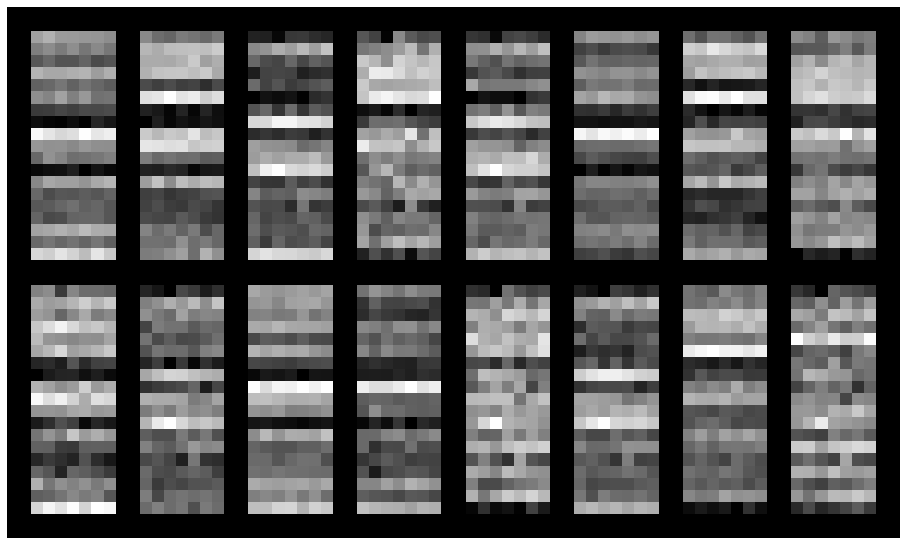

Epoch: [399/400], Batch Num: [50/54]
Discriminator Loss: 1.1169, Generator Loss: 1.4595
D(x): 0.6639, D(G(z)): 0.3403


In [14]:
logger = Logger(model_name='VGAN', data_name='MNIST')

for epoch in range(num_epochs):
    for n_batch, (real_batch) in enumerate(train_dataloader):

        # 1. Train Discriminator
        real_data = Variable(images_to_vectors(real_batch))
        if torch.cuda.is_available(): real_data = real_data.cuda()
        # Generate fake data
        fake_data = generator(noise(real_data.size(0))).detach()
        # Train D
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer,
                                                                real_data, fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(real_batch.size(0)))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        # Log error
        logger.log(d_error, g_error, epoch, n_batch, num_batches_train)

        # Display Progress
        if (n_batch) % 10 == 0:
            display.clear_output(True)
            # Display Images
            test_images = vectors_to_images(generator(test_noise)).data.cpu()
            logger.log_images(test_images, num_test_samples, epoch, n_batch, num_batches_train);
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches_train,
                d_error, g_error, d_pred_real, d_pred_fake
            )
        # Model Checkpoints
        logger.save_models(generator, discriminator, epoch)

In [ ]:
mean_list = []
std_list = []
for item in real_data:
#     print(torch.mean(item),torch.std(item))
    mean_list.append(torch.mean(item).cpu().numpy())
    std_list.append(torch.std(item).cpu().numpy())

In [19]:
len(tensor_array)

NameError: name 'tensor_array' is not defined

In [ ]:
mean_list = []
std_list = []
for item in tensor_array:
    mean_list.append(np.mean(item))
    std_list.append(np.std(item))

In [15]:
g2 = generator(noise(29898))
mean_g2 = torch.mean(g2,axis=1)
mean_g2 = mean_g2.cpu().detach().numpy()
std_g2 = torch.std(g2,axis=1)
std_g2 = std_g2.cpu().detach().numpy()
print(mean_g2.shape)
print(std_g2.shape)

(29898,)
(29898,)


(array([3.790e+02, 2.155e+03, 3.706e+03, 4.424e+03, 4.060e+03, 3.249e+03,
        2.514e+03, 1.840e+03, 1.422e+03, 1.082e+03, 8.540e+02, 6.640e+02,
        5.500e+02, 3.920e+02, 3.350e+02, 2.610e+02, 2.370e+02, 1.960e+02,
        1.620e+02, 1.440e+02, 1.080e+02, 1.160e+02, 9.400e+01, 8.600e+01,
        8.900e+01, 8.700e+01, 7.100e+01, 6.500e+01, 4.200e+01, 5.300e+01,
        4.300e+01, 3.700e+01, 4.700e+01, 3.000e+01, 3.200e+01, 2.600e+01,
        2.100e+01, 1.300e+01, 2.300e+01, 1.800e+01, 1.600e+01, 2.000e+01,
        1.500e+01, 1.200e+01, 1.000e+01, 1.200e+01, 5.000e+00, 9.000e+00,
        1.000e+01, 2.000e+00, 8.000e+00, 2.000e+00, 1.000e+01, 5.000e+00,
        5.000e+00, 0.000e+00, 7.000e+00, 4.000e+00, 2.000e+00, 4.000e+00,
        0.000e+00, 1.000e+00, 3.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        2.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

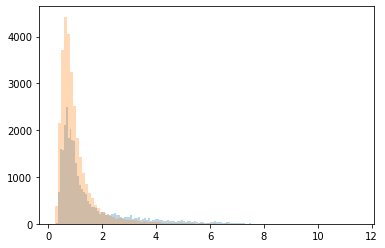

In [25]:
plt.hist(std_list,bins=100,label='origin',alpha=0.3)
plt.hist(std_g2,bins=100,label='generator',alpha=0.3)

/home/esmidth/.pyenv/versions/anaconda3-2020.02/envs/ccs_ta/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/esmidth/.pyenv/versions/anaconda3-2020.02/envs/ccs_ta/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([2.000e+00, 5.000e+00, 1.200e+01, 2.700e+01, 1.050e+02, 2.730e+02,
        5.840e+02, 1.166e+03, 1.895e+03, 2.465e+03, 2.407e+03, 2.368e+03,
        2.103e+03, 1.924e+03, 1.691e+03, 1.517e+03, 1.381e+03, 1.155e+03,
        9.800e+02, 8.460e+02, 7.840e+02, 6.810e+02, 5.950e+02, 5.260e+02,
        4.580e+02, 4.190e+02, 3.580e+02, 3.450e+02, 2.730e+02, 2.890e+02,
        2.360e+02, 2.210e+02, 2.160e+02, 1.700e+02, 1.450e+02, 1.390e+02,
        1.180e+02, 9.800e+01, 1.120e+02, 8.300e+01, 7.300e+01, 6.900e+01,
        6.100e+01, 6.200e+01, 6.300e+01, 5.100e+01, 4.700e+01, 3.200e+01,
        3.900e+01, 2.100e+01, 2.100e+01, 1.900e+01, 2.800e+01, 2.400e+01,
        1.100e+01, 1.300e+01, 1.500e+01, 1.000e+01, 4.000e+00, 1.000e+01,
        6.000e+00, 1.000e+01, 6.000e+00, 2.000e+00, 6.000e+00, 2.000e+00,
        2.000e+00, 1.000e+00, 3.000e+00, 6.000e+00, 3.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

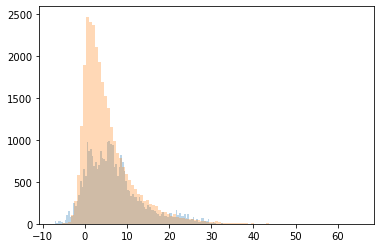

In [24]:
plt.hist(mean_list,bins=100,label='y',alpha=0.3)
plt.hist(mean_g2,bins=100,label='x',alpha=0.3)

In [ ]:
plt.hist(mean_g2,bins=100)

In [ ]:
g2_np = g2.cpu().detach().numpy()

In [ ]:
mean_g2 = torch

In [47]:
while True:
    g1 = generator(noise(1))
    loss = g1.cpu().detach().numpy().reshape(19,7) - tensor_array[10000]
    mre = np.sum(np.abs(loss))
    if mre < 40:
        print(mre)
        break
print(g1)
print(discriminator(g1))

38.0456715554744
tensor([[ 0.8285,  0.8485,  0.7159,  0.7322,  0.8671,  0.7196,  0.7622,  0.5088,
          0.7056,  0.4969,  0.6247,  0.7937,  0.6051,  0.4890,  0.4596,  0.5818,
          0.5167,  0.4033,  0.5060,  0.4977,  0.4898,  0.8874,  0.9665,  0.8486,
          0.9338,  0.9195,  0.8351,  0.9480,  0.3315,  0.4599,  0.4690,  0.4157,
          0.5156,  0.4293,  0.3232,  1.0698,  0.9208,  1.0228,  1.0739,  0.9940,
          0.9027,  0.7259, -0.0232, -0.0362, -0.0532, -0.2386, -0.0981,  0.0465,
          0.0393, -0.1203, -0.1459, -0.1352, -0.1143, -0.1832, -0.1120, -0.0659,
          2.0377,  1.8728,  2.0891,  2.0692,  2.1088,  1.9515,  2.1848,  0.9232,
          0.8378,  0.8498,  0.7381,  0.8106,  0.7488,  0.8000,  0.4071,  0.4997,
          0.5672,  0.3864,  0.3402,  0.3736,  0.4601, -0.3087,  0.0056, -0.1810,
         -0.1222, -0.2345, -0.0928, -0.0621,  0.6936,  0.8074,  0.8171,  0.9077,
          0.8581,  0.8020,  1.0585,  0.5790,  0.3497,  0.3235,  0.4460,  0.5628,
          0

In [52]:
tensor_array[10000]

array([[ 0.475,  0.6  ,  0.662,  0.6  ,  0.787,  0.662,  0.662],
       [ 0.412,  0.475,  0.662,  0.537,  0.6  ,  0.662,  0.662],
       [ 0.163,  0.037,  0.1  ,  0.037,  0.225,  0.037,  0.225],
       [ 0.475,  0.412,  0.6  ,  0.475,  0.475,  0.412,  0.35 ],
       [ 0.787,  0.725,  0.537,  0.662,  0.6  ,  0.537,  0.662],
       [ 0.225,  0.1  ,  0.1  , -0.087, -0.087,  0.1  , -0.087],
       [-0.025, -0.025, -0.025, -0.212, -0.338, -0.025, -0.275],
       [-0.588, -0.65 , -0.713, -0.525, -0.525, -0.525, -0.525],
       [ 2.1  ,  2.1  ,  2.163,  2.225,  2.225,  2.163,  2.1  ],
       [ 1.038,  0.85 ,  0.975,  0.912,  0.912,  0.912,  0.912],
       [ 0.225,  0.412,  0.412,  0.163,  0.537,  0.475,  0.412],
       [ 0.037,  0.037,  0.1  ,  0.1  ,  0.037, -0.087,  0.037],
       [ 0.662,  0.537,  0.725,  0.475,  0.662,  0.412,  0.475],
       [ 0.975,  0.85 ,  0.787,  0.725,  0.725,  0.85 ,  0.787],
       [ 0.163,  0.287,  0.287,  0.163,  0.287,  0.35 ,  0.412],
       [ 0.787,  0.787,  

In [54]:
loss

array([[ 0.35348954,  0.24852695,  0.05388176,  0.13216552,  0.0801118 ,
         0.05755645,  0.10023725],
       [ 0.09675545,  0.23060825, -0.16513672,  0.08768153,  0.19373288,
        -0.05690765, -0.17298955],
       [ 0.29664596,  0.54484308,  0.41665479,  0.36629421,  0.28103819,
         0.46074444,  0.26476815],
       [ 0.41243889,  0.55451155,  0.24856838,  0.45881375,  0.44445142,
         0.42312825,  0.59801039],
       [-0.45553899, -0.26514575, -0.06804028, -0.24632415, -0.08440909,
        -0.10769856, -0.33881426],
       [ 0.84479132,  0.8207778 ,  0.92284896,  1.16092788,  1.08099561,
         0.80271032,  0.81290625],
       [ 0.00184813, -0.01118294, -0.02818374, -0.02655282,  0.23987109,
         0.0715357 ,  0.31433735],
       [ 0.4677287 ,  0.5040594 ,  0.5777738 ,  0.41072703,  0.34180989,
         0.41297063,  0.45909437],
       [-0.06232772, -0.22718892, -0.07393659, -0.15577469, -0.11617599,
        -0.21148814,  0.08478775],
       [-0.11476744, -0.0122

In [27]:
dif = []
g3 = generator(noise(100000))
for item in g3:
    dif.append(np.sum(np.abs(item.cpu().detach().numpy().reshape(19,7)-tensor_array[1])))

In [44]:
dif = []
for item in g3:
    dif.append(np.sum(np.abs(item.cpu().detach().numpy().reshape(19,7)-tensor_array[10000])))
print(np.min(dif))

36.4557402940318


In [45]:
np.min(dif) / 133

0.2741033104814421

In [33]:
np.max(dif)

6552.870897216797

In [38]:
np.min(dif)

62.10247220611572

In [ ]:
# RMSE
np.sqrt(np.sum(np.power(loss,2)) / 133)

In [ ]:
np.sum(np.abs(loss)) 

In [ ]:
# MSE
np.sum(np.power(loss,2)) / 133

In [ ]:
loss

In [ ]:
mre

In [ ]:
g2 = generator(noise(1))

In [ ]:
np.sum(np.abs(loss))

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
std_list

In [ ]:
plt.hist(mean_list,bins=100)

In [ ]:
plt.hist(std_list,bins=100)

In [21]:
cd ..

/home/esmidth/github/CCS_TA_implement


In [22]:
import pickle
with open('tensor2.pkl','rb') as f:
    tensor_array = pickle.load(f)

In [23]:
mean_list = []
std_list = []
for item in tensor_array:
    mean_list.append(np.mean(item))
    std_list.append(np.std(item))